In [82]:
import os
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [83]:
def construct_df():
    arabic_letters = [
        # Hamza variations
        '\u0621', '\u0622', '\u0623', '\u0625', '\u0627', 
        '\u0671', '\u0672', '\u0673', '\u0674', '\u0675',
        
        # Ba variations
        '\u0628', '\u066E', '\u067B', '\u067E', '\u0680', 
        
        # Ta variations
        '\u062A', '\u067A', '\u062B', 
        
        # Other letters
        '\u062C', '\u062D', '\u062E', '\u062F', '\u0630', 
        '\u0631', '\u0632', '\u0633', '\u0634', '\u0635', 
        '\u0636', '\u0637', '\u0638', '\u0639', '\u063A', 
        '\u0641', '\u0642', '\u0643', '\u0644', '\u0645', 
        '\u0646', '\u0647', '\u06C1', '\u06C3', 
        
        # Waw and Ya variations
        '\u0648', '\u0624', '\u0620', '\u0649', '\u064A', 
        '\u06CC', 
        
        # Space
        '\u0020'
    ]
    
    df = pd.DataFrame({
        "letter": arabic_letters,
        "frequency": [0] * len(arabic_letters)
    })
    
    return df



In [84]:
def tokenize_characters(text, strip_non_alphanum=False):
    if strip_non_alphanum:
        text = re.sub(r'[^\w\s]', '', text)
    return list(text)

def arabic_characters_frequency(corpus_of_text):
    # Construct the dataframe with Arabic letters and initialized frequencies
    arabic_letters_frequency = construct_df()
    
    # Iterate through each text in the corpus
    for text in corpus_of_text['corpus']:
        # Tokenize the text into characters
        characters = tokenize_characters(text)
        
        # Count frequencies
        for char in characters:
            # Find the index of the character in the dataframe
            mask = arabic_letters_frequency['letter'] == char
            
            # Increment frequency if the character is found
            if mask.any():
                arabic_letters_frequency.loc[mask, 'frequency'] += 1
    
    return arabic_letters_frequency

In [85]:
# Sample corpus (equivalent to the R dataframe)
corpus_of_text = pd.DataFrame({
    'corpus': ['على احمد محمد', 'محمد عبد العزيز خميس', 'وليد السيد على']
})

# Function to compute the frequency of Arabic letters in the corpus
freqs = arabic_characters_frequency(corpus_of_text)

# Display the frequency dataframe
print(freqs)

# Calculate and print the total number of letters in the corpus
total_letters = freqs['frequency'].sum()
print(f"The corpus contains a total of: {total_letters} letters.")

   letter  frequency
0       ء          0
1       آ          0
2       أ          0
3       إ          0
4       ا          3
5       ٱ          0
6       ٲ          0
7       ٳ          0
8       ٴ          0
9       ٵ          0
10      ب          1
11      ٮ          0
12      ٻ          0
13      پ          0
14      ڀ          0
15      ت          0
16      ٺ          0
17      ث          0
18      ج          0
19      ح          3
20      خ          1
21      د          6
22      ذ          0
23      ر          0
24      ز          2
25      س          2
26      ش          0
27      ص          0
28      ض          0
29      ط          0
30      ظ          0
31      ع          4
32      غ          0
33      ف          0
34      ق          0
35      ك          0
36      ل          5
37      م          6
38      ن          0
39      ه          0
40      ہ          0
41      ۃ          0
42      و          1
43      ؤ          0
44      ؠ          0
45      ى          2
46      ي    

In [86]:
def normalize_arabic_letters(freqs):
    normalization_map = {
        # Alif variations
        'alif_group': ['\u0621', '\u0622', '\u0623', '\u0625', '\u0627', 
                       '\u0671', '\u0672', '\u0673', '\u0674', '\u0675'],
        
        # Ba variations
        'ba_group': ['\u0628', '\u066E', '\u067B', '\u067E', '\u0680'],
        
        # Ta variations
        'ta_group': ['\u062A', '\u067A', '\u062B'],
        
        # Haa variations
        'haa_group': ['\u0647', '\u06C1', '\u06C3'],
        
        # Waw variations
        'waw_group': ['\u0648', '\u0624', '\u0620'],
        
        # Ya variations
        'ya_group': ['\u0649', '\u064A', '\u06CC']
    }
    
    # Create a list to store normalized frequencies
    normalized_data = []
    
    # Normalize frequencies
    for group_name, letter_group in normalization_map.items():
        group_freq = freqs[freqs['letter'].isin(letter_group)]['frequency'].sum()
        normalized_data.append({
            'letter_group': group_name, 
            'frequency': group_freq
        })
    
    # Add space separately
    space_freq = freqs[freqs['letter'] == '\u0020']['frequency'].sum()
    normalized_data.append({
        'letter_group': 'space', 
        'frequency': space_freq
    })
    
    # Convert to DataFrame
    normalized_freqs = pd.DataFrame(normalized_data)
    
    return normalized_freqs



In [87]:
def extract_prob_dist(frequency):
    # Compute total sample size
    total = frequency['frequency'].sum()
    
    # Normalize to get probability distribution
    prob_dist = frequency['frequency'] / total
    
    return prob_dist

def entropy(prob_dist):
    # Remove zero probabilities
    non_zero_probs = prob_dist[prob_dist > 0]
    
    # Compute entropy
    return -np.sum(non_zero_probs * np.log2(non_zero_probs))

In [88]:
def main():
    # Load songs data
    DATA_PATH = r"D:\term 8\deep learning\research project\songs.xlsx"
    
    try:
        # Load Excel file
        songs = pd.read_excel(DATA_PATH)
        
        # Extract lyrics
        lyrics = pd.DataFrame({
            'corpus': songs['Lyrics'].dropna()
        })
        
        print(f"Total number of songs: {len(lyrics)}")
        
        # Calculate letter frequencies
        start_time = time.time()
        freqs = arabic_characters_frequency(lyrics)
        
        # Normalize frequencies
        normalized_freqs = normalize_arabic_letters(freqs)
        
        # Calculate probability distribution
        prob_dist = extract_prob_dist(normalized_freqs)
        
        # Calculate entropy
        entropy_value = entropy(prob_dist)
        
        end_time = time.time()
        
        print(f"Entropy of the lyrics: {entropy_value}")
        print(f"Processing time: {end_time - start_time:.2f} seconds")
        
        # Optional: Save frequencies to CSV
        freqs.to_csv(r"D:\term 8\deep learning\research project\entropy\frequencies.csv", index=False)
        normalized_freqs.to_csv(r"D:\term 8\deep learning\research project\entropy\normalized_frequencies.csv", index=False)
        
    except Exception as e:
        print(f"An error occurred: {e}")
        # Optional: print traceback for more detailed error information
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Total number of songs: 310
Entropy of the lyrics: 2.5123773010471995
Processing time: 143.62 seconds


In [89]:
def compute_corpus_entropy(lyrics_df):
    """Compute the entropy of the whole corpus"""
    # Create a dataframe with only the lyrics column
    lyrics_corpus = pd.DataFrame({
        'corpus': lyrics_df['Lyrics'].dropna()
    })
    
    # Calculate letter frequencies
    freqs = arabic_characters_frequency(lyrics_corpus)
    
    # Normalize frequencies
    letter_normalized_freqs = normalize_arabic_letters(freqs)
    
    # Calculate probability distribution
    prob_dist = extract_prob_dist(letter_normalized_freqs)
    
    # Calculate entropy
    corpus_entropy = entropy(prob_dist)
    
    print(f"The entropy of the whole corpus is: {corpus_entropy}")
    
    return corpus_entropy

In [90]:
def compute_song_entropy(lyrics_df):
    """Compute entropy for every song in the corpus"""
    N = len(lyrics_df)  # get the total number of songs
    song_entropy = []
    
    for i in range(N):
        # Get lyrics of current song
        ly = pd.DataFrame({
            'corpus': [lyrics_df.iloc[i]['Lyrics']]
        })
        
        # Skip if lyrics is NaN
        if pd.isna(ly['corpus'][0]):
            song_entropy.append(np.nan)
            continue
            
        # Compute the histogram/frequency of all Arabic letters with all variations
        freqs = arabic_characters_frequency(ly)
        
        # Normalize Arabic letters
        letter_normalized_freqs = normalize_arabic_letters(freqs)
        
        # Convert the histogram into proper empirical probability mass function
        prob_dist = extract_prob_dist(letter_normalized_freqs)
        
        # Calculate entropy
        song_entropy.append(entropy(prob_dist))
    
    # Add entropy values to lyrics dataframe
    lyrics_df['entropy'] = song_entropy
    
    # Find min and max entropy songs
    valid_entropy = lyrics_df.dropna(subset=['entropy'])
    
    min_entropy_song = valid_entropy.loc[valid_entropy['entropy'].idxmin()]
    max_entropy_song = valid_entropy.loc[valid_entropy['entropy'].idxmax()]
    
    print(f"The song with minimum entropy: {min_entropy_song['Song']}")
    print(f"It has a minimum entropy of: {min_entropy_song['entropy']}")
    print(f"The song with maximum entropy: {max_entropy_song['Song']}")
    print(f"It has a maximum entropy of: {max_entropy_song['entropy']}")
    
    return lyrics_df

In [91]:
def plot_entropy_histogram(lyrics_df):
    """Plot histogram of entropy values across songs"""
    plt.figure(figsize=(10, 6))
    
    # Drop NaN entropy values
    valid_entropy = lyrics_df.dropna(subset=['entropy'])
    
    # Create histogram
    plt.hist(valid_entropy['entropy'], bins=20, color='lightblue', edgecolor='black')
    
    # Add title and labels
    plt.title('Histogram of entropy values of individual songs')
    plt.xlabel('Entropy')
    plt.ylabel('Frequency')
    
    # Customize x-axis
    min_entropy = round(valid_entropy['entropy'].min(), 1)
    max_entropy = round(valid_entropy['entropy'].max(), 1)
    plt.xticks(np.arange(min_entropy, max_entropy + 0.1, 0.1))
    plt.xticks(rotation=45)
    
    # Save and show plot
    plt.tight_layout()
    plt.savefig(r"D:\term 8\deep learning\research project\entropy\entropy_histogram.png")
    plt.show()

In [92]:
def compute_entropy_per_year(songs_df):
    """Compute entropy for each year"""
    # Group by year
    years = songs_df['Year'].dropna().unique()
    yearly_entropy = []
    
    for year in years:
        # Get songs from this year
        year_songs = songs_df[songs_df['Year'] == year]
        
        # Create lyrics corpus for this year
        year_lyrics = pd.DataFrame({
            'corpus': year_songs['Lyrics'].dropna()
        })
        
        # Skip if no lyrics available for this year
        if len(year_lyrics) == 0:
            continue
            
        # Compute frequencies
        freqs = arabic_characters_frequency(year_lyrics)
        
        # Normalize frequencies
        letter_normalized_freqs = normalize_arabic_letters(freqs)
        
        # Calculate probability distribution
        prob_dist = extract_prob_dist(letter_normalized_freqs)
        
        # Calculate entropy
        yearly_entropy.append({
            'Year': year,
            'entropy': entropy(prob_dist)
        })
    
    # Convert to DataFrame
    yearly_entropy_df = pd.DataFrame(yearly_entropy)
    
    return yearly_entropy_df

In [93]:
def plot_yearly_entropy(yearly_entropy_df):
    """Plot entropy over years with trend lines"""
    plt.figure(figsize=(12, 6))
    
    # Scatter plot
    plt.scatter(yearly_entropy_df['Year'], yearly_entropy_df['entropy'], 
                alpha=0.4, color='darkblue', s=30)
    
    # Linear regression
    x = yearly_entropy_df['Year']
    y = yearly_entropy_df['entropy']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.array([min(x), max(x)])
    line_y = slope * line_x + intercept
    plt.plot(line_x, line_y, color='black', label=f'Linear (r={r_value:.2f})')
    
    # LOESS/LOWESS smoothing using seaborn
    sns.regplot(x='Year', y='entropy', data=yearly_entropy_df, 
                scatter=False, lowess=True, color='red', line_kws={'lw': 2})
    
    # Add title and labels
    plt.title('Yearly Entropy')
    plt.xlabel('Year')
    plt.ylabel('Entropy')
    
    # Customize axes
    plt.xticks(np.arange(min(yearly_entropy_df['Year']), max(yearly_entropy_df['Year']) + 1, 1), 
               rotation=45)
    plt.yticks(np.arange(round(min(yearly_entropy_df['entropy']), 2), 
                         round(max(yearly_entropy_df['entropy']), 2) + 0.01, 0.01))
    
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Save and show plot
    plt.savefig(r"D:\term 8\deep learning\research project\entropy\yearly_entropy.png")
    plt.show()



In [94]:
def compute_entropy_per_decade(songs_df):
    """Compute entropy for each decade"""
    # Create decade column
    songs_df['Decade'] = (songs_df['Year'] // 10) * 10
    
    # Group by decade
    decades = songs_df['Decade'].dropna().unique()
    decade_entropy = []
    
    for decade in decades:
        # Get songs from this decade
        decade_songs = songs_df[songs_df['Decade'] == decade]
        
        # Create lyrics corpus for this decade
        decade_lyrics = pd.DataFrame({
            'corpus': decade_songs['Lyrics'].dropna()
        })
        
        # Skip if no lyrics available for this decade
        if len(decade_lyrics) == 0:
            continue
            
        # Compute frequencies
        freqs = arabic_characters_frequency(decade_lyrics)
        
        # Normalize frequencies
        letter_normalized_freqs = normalize_arabic_letters(freqs)
        
        # Calculate probability distribution
        prob_dist = extract_prob_dist(letter_normalized_freqs)
        
        # Calculate entropy
        decade_entropy.append({
            'Decade': decade,
            'entropy': entropy(prob_dist)
        })
    
    # Convert to DataFrame
    decade_entropy_df = pd.DataFrame(decade_entropy)
    
    return decade_entropy_df



In [95]:
def plot_decade_entropy(decade_entropy_df):
    """Plot entropy by decade as a bar chart"""
    plt.figure(figsize=(10, 6))
    
    # Bar chart
    plt.bar(decade_entropy_df['Decade'].astype(str), decade_entropy_df['entropy'], 
            color='lightblue', edgecolor='black')
    
    # Add title and labels
    plt.title('Entropy by Decade')
    plt.xlabel('Decade')
    plt.ylabel('Entropy')
    
    # Add value labels on top of bars
    for i, v in enumerate(decade_entropy_df['entropy']):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    # Save and show plot
    plt.savefig(r"D:\term 8\deep learning\research project\entropy\decade_entropy.png")
    plt.show()



Loading songs data...
Total number of songs with lyrics: 310

--- Computing corpus entropy ---
The entropy of the whole corpus is: 2.5123773010471995

--- Computing song entropy ---
The song with minimum entropy: لا لا
It has a minimum entropy of: 1.6237045228232625
The song with maximum entropy: بلاش تكلمها
It has a maximum entropy of: 2.682116663807732

--- Plotting entropy histogram ---


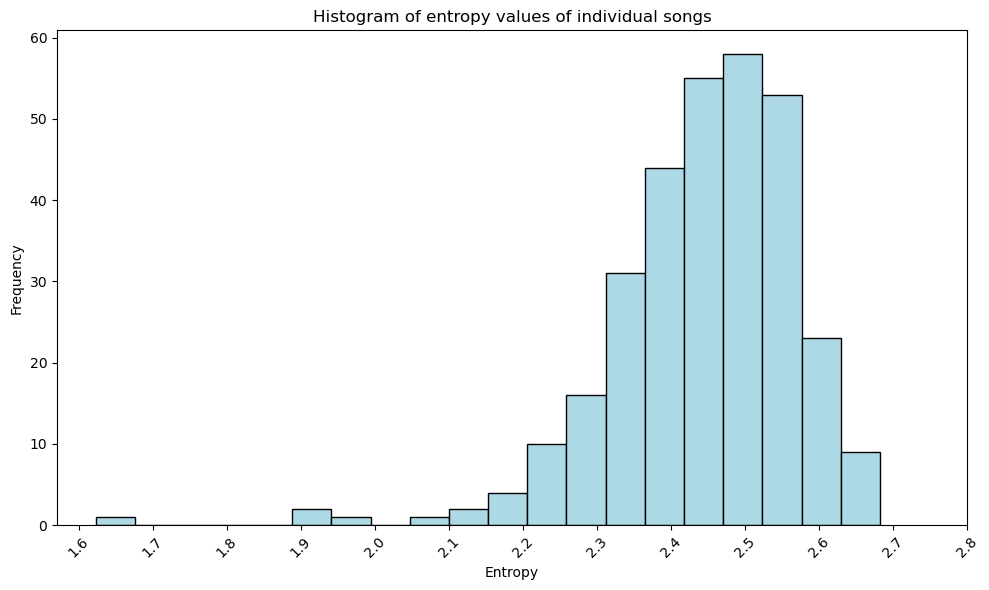


--- Computing yearly entropy ---

--- Plotting yearly entropy ---


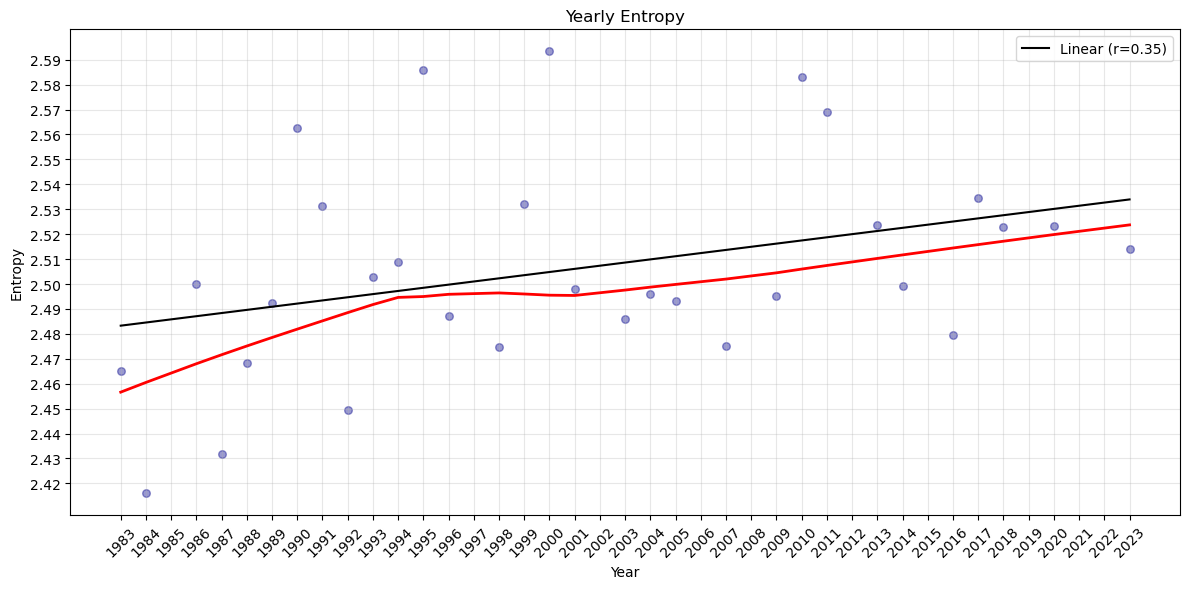


--- Computing decade entropy ---

--- Plotting decade entropy ---


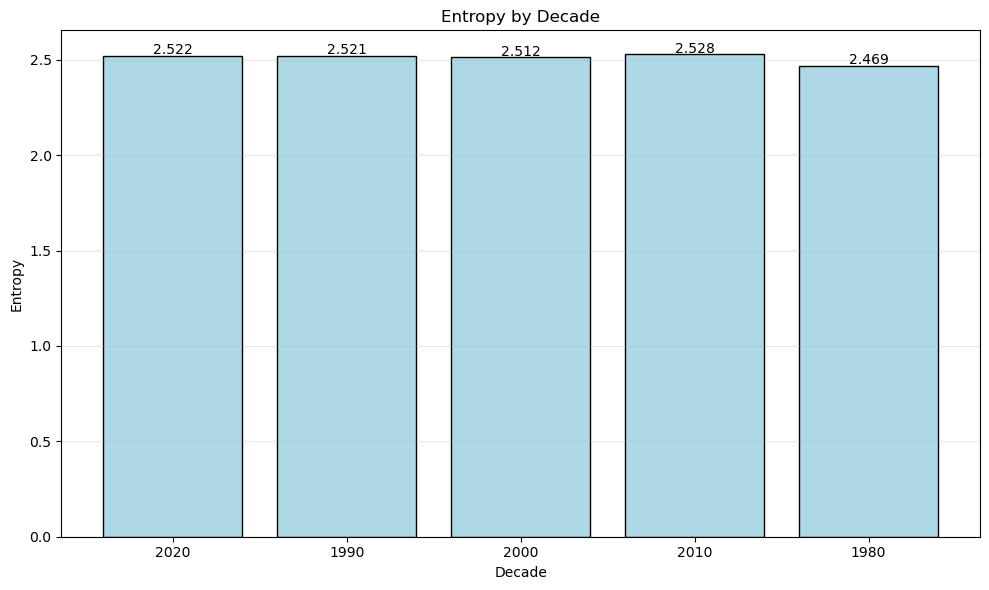


--- Saving results ---

Analysis complete. Results and plots saved.


In [96]:
def main():
    # Load songs data
    DATA_PATH = r"D:\term 8\deep learning\research project\songs.xlsx"
    
    try:
        # Load Excel file
        print("Loading songs data...")
        songs = pd.read_excel(DATA_PATH)
        
        # Extract lyrics for whole corpus entropy
        lyrics = pd.DataFrame({
            'Song': songs['Song'],
            'Year': songs['Year'],
            'Lyrics': songs['Lyrics'].dropna()
        })
        
        print(f"Total number of songs with lyrics: {len(lyrics)}")
        
        # 1. Compute corpus entropy
        print("\n--- Computing corpus entropy ---")
        corpus_entropy = compute_corpus_entropy(lyrics)
        
        # 2. Compute song entropy
        print("\n--- Computing song entropy ---")
        lyrics_with_entropy = compute_song_entropy(lyrics)
        
        # 3. Plot entropy histogram
        print("\n--- Plotting entropy histogram ---")
        plot_entropy_histogram(lyrics_with_entropy)
        
        # 4. Compute and plot yearly entropy
        print("\n--- Computing yearly entropy ---")
        yearly_entropy = compute_entropy_per_year(songs)
        print("\n--- Plotting yearly entropy ---")
        plot_yearly_entropy(yearly_entropy)
        
        # 5. Compute and plot decade entropy
        print("\n--- Computing decade entropy ---")
        decade_entropy = compute_entropy_per_decade(songs)
        print("\n--- Plotting decade entropy ---")
        plot_decade_entropy(decade_entropy)
        
        # Save results
        print("\n--- Saving results ---")
        lyrics_with_entropy.to_csv(r"D:\term 8\deep learning\research project\entropy\songs_with_entropy.csv", index=False)
        yearly_entropy.to_csv(r"D:\term 8\deep learning\research project\entropy\yearly_entropy.csv", index=False)
        decade_entropy.to_csv(r"D:\term 8\deep learning\research project\entropy\decade_entropy.csv", index=False)
        
        print("\nAnalysis complete. Results and plots saved.")
        
    except Exception as e:
        print(f"An error occurred: {e}")
        # Optional: print traceback for more detailed error information
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [97]:
def compute_entropy_by_named_decade(songs_df):
    """
    Compute entropy for each named decade period (Early/Late 1940s, 1950s, etc.)
    """
    # Create a copy of the dataframe
    songs = songs_df.copy()
    
    # Sort by Year
    songs = songs.sort_values('Year')
    
    # Create named decade column
    def assign_named_decade(year):
        if pd.isna(year):
            return np.nan
        year = int(year)
        if 1945 <= year <= 1949:
            return "Late 1940s"
        elif 1950 <= year <= 1954:
            return "Early 1950s"
        elif 1955 <= year <= 1959:
            return "Late 1950s"
        elif 1960 <= year <= 1964:
            return "Early 1960s"
        elif 1965 <= year <= 1969:
            return "Late 1960s"
        elif 1970 <= year <= 1974:
            return "Early 1970s"
        elif 1975 <= year <= 1979:
            return "Late 1970s"
        elif 1980 <= year <= 1984:
            return "Early 1980s"
        elif 1985 <= year <= 1989:
            return "Late 1980s"
        else:
            return np.nan
            
    songs['Decade'] = songs['Year'].apply(assign_named_decade)
    
    # Extract only songs with available lyrics
    lyrics = pd.DataFrame({
        'Decade': songs['Decade'],
        'Song': songs['Song'],
        'Lyrics': songs['Lyrics']
    })
    
    # Drop rows with NaN values
    lyrics = lyrics.dropna()
    
    # Add numeric years and part (early/late) columns for sorting
    def extract_year(decade_str):
        if pd.isna(decade_str):
            return np.nan
        # Extract numeric part using regex
        match = re.search(r'(\d{4})', decade_str)
        if match:
            return int(match.group(1))
        return np.nan
    
    lyrics['years'] = lyrics['Decade'].apply(extract_year)
    lyrics['part'] = lyrics['Decade'].apply(lambda x: 0 if 'Early' in str(x) else 1)
    
    # Sort by years and part
    lyrics = lyrics.sort_values(['years', 'part'])
    
    # Define decade order for proper sorting in plots
    decade_order = [
        "Late 1940s", "Early 1950s", "Late 1950s", 
        "Early 1960s", "Late 1960s", "Early 1970s", 
        "Late 1970s", "Early 1980s", "Late 1980s"
    ]
    
    # Convert Decade to categorical type with specified order
    lyrics['Decade'] = pd.Categorical(
        lyrics['Decade'],
        categories=decade_order,
        ordered=True
    )
    
    # Compute entropy by decade
    decade_entropy = []
    
    # Group by decade
    for decade in decade_order:
        # Get lyrics for this decade
        decade_lyrics = lyrics[lyrics['Decade'] == decade]
        
        # Skip if no lyrics for this decade
        if len(decade_lyrics) == 0:
            continue
        
        # Create corpus dataframe
        decade_corpus = pd.DataFrame({
            'corpus': decade_lyrics['Lyrics']
        })
        
        # Compute frequencies
        freqs = arabic_characters_frequency(decade_corpus)
        
        # Normalize frequencies
        letter_normalized_freqs = normalize_arabic_letters(freqs)
        
        # Calculate probability distribution
        prob_dist = extract_prob_dist(letter_normalized_freqs)
        
        # Calculate entropy
        decade_entropy.append({
            'Decade': decade,
            'val': entropy(prob_dist)
        })
    
    # Convert to DataFrame
    decade_entropy_df = pd.DataFrame(decade_entropy)
    
    return decade_entropy_df, lyrics

In [98]:
def plot_named_decade_entropy(decade_entropy_df, corpus_entropy):
    """
    Plot entropy by named decade as a bar chart
    """
    plt.figure(figsize=(12, 6))
    
    # Create bar chart
    plt.bar(decade_entropy_df['Decade'], decade_entropy_df['val'], 
            color='darkblue', edgecolor='black')
    
    # Add horizontal line for corpus entropy
    plt.axhline(y=corpus_entropy, color='red', linestyle='dashed', 
                label='Corpus Entropy')
    
    # Add title and labels
    plt.title('Entropy by Decade')
    plt.ylabel('Entropy')
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Set y-axis ticks
    plt.yticks(np.arange(0, 4.5, 0.2))
    
    # Add grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.legend()
    plt.tight_layout()
    
    # Save and show plot
    plt.savefig(r"D:\term 8\deep learning\research project\entropy\named_decade_entropy.png")
    plt.show()
    
    return plt

Loading songs data...
Total number of songs with lyrics: 310

--- Computing corpus entropy ---
The entropy of the whole corpus is: 2.5123773010471995

--- Computing named decade entropy ---
Entropy values by named decade:
        Decade       val
0  Early 1980s  2.439527
1   Late 1980s  2.480539

--- Plotting named decade entropy ---


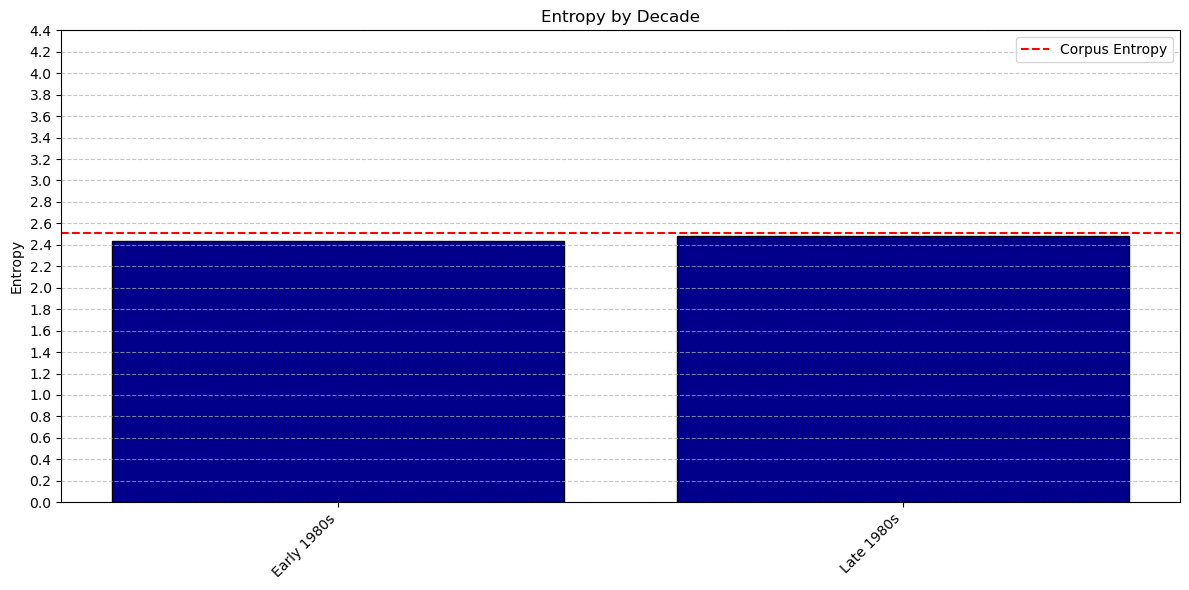


--- Saving results ---

Named decade analysis complete. Results and plots saved.


In [99]:
# Update the main function to include the named decade analysis
def main():
    # Load songs data
    DATA_PATH = r"D:\term 8\deep learning\research project\songs.xlsx"
    
    try:
        # Load Excel file
        print("Loading songs data...")
        songs = pd.read_excel(DATA_PATH)
        
        # Extract lyrics for whole corpus entropy
        lyrics = pd.DataFrame({
            'Song': songs['Song'],
            'Year': songs['Year'],
            'Lyrics': songs['Lyrics'].dropna()
        })
        
        print(f"Total number of songs with lyrics: {len(lyrics)}")
        
        # 1. Compute corpus entropy first (needed for comparison in decade plot)
        print("\n--- Computing corpus entropy ---")
        lyrics_corpus = pd.DataFrame({
            'corpus': lyrics['Lyrics'].dropna()
        })
        
        # Calculate letter frequencies
        freqs = arabic_characters_frequency(lyrics_corpus)
        letter_normalized_freqs = normalize_arabic_letters(freqs)
        prob_dist = extract_prob_dist(letter_normalized_freqs)
        corpus_entropy = entropy(prob_dist)
        
        print(f"The entropy of the whole corpus is: {corpus_entropy}")
        
        # 2. Compute and plot named decade entropy
        print("\n--- Computing named decade entropy ---")
        named_decade_entropy, lyrics_with_decade = compute_entropy_by_named_decade(songs)
        
        print("Entropy values by named decade:")
        print(named_decade_entropy)
        
        print("\n--- Plotting named decade entropy ---")
        plot_named_decade_entropy(named_decade_entropy, corpus_entropy)
        
        # Save results
        print("\n--- Saving results ---")
        named_decade_entropy.to_csv(r"D:\term 8\deep learning\research project\entropy\named_decade_entropy.csv", index=False)
        lyrics_with_decade.to_csv(r"D:\term 8\deep learning\research project\entropy\lyrics_with_decade.csv", index=False)
        
        print("\nNamed decade analysis complete. Results and plots saved.")
        
    except Exception as e:
        print(f"An error occurred: {e}")
        # Optional: print traceback for more detailed error information
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()